In [30]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import het_breuschpagan
from statsmodels.regression.linear_model import OLS
import statsmodels.api as sm
import numpy as np
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.api import VAR
from statsmodels.tools.tools import add_constant

In [29]:
pip install pmdarima

  Obtaining dependency information for pmdarima from https://files.pythonhosted.org/packages/40/e5/78afab229ccdaf6b947036440799dbdf88e2cd632e2f96b81f32de8aa05a/pmdarima-2.0.4-cp311-cp311-macosx_11_0_arm64.whl.metadata
  Obtaining dependency information for Cython!=0.29.18,!=0.29.31,>=0.29 from https://files.pythonhosted.org/packages/fb/fe/e213d8e9cb21775bb8f9c92ff97861504129e23e33d118be1a90ca26a13e/Cython-3.0.5-py2.py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 628.0/628.0 kB 525.9 kB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 1.4 MB/s eta 0:00:0000:0100:01m
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tables 3.8.0 requires blosc2~=2.0.0, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [2]:
df = pd.read_excel('10 - Моргунова Карина.xlsx')
df

,Выручка,Кол-во торговых точек,Инфляция
0,1000.000000,1000,2.37
1,1028.891529,1013,1.65
2,1058.362078,1037,1.31
3,1085.952172,1063,0.69
4,1112.591510,1083,0.57
...,...,...,...
139,2967.578088,2818,-0.04
140,2975.525361,2820,-0.07
141,2983.281426,2830,0.43
142,2982.068962,2843,0.71


1. Проверка ряда (выручки) на стационарность

In [8]:
test = adfuller(df['Выручка'])

print(f'F-stat: {test[0]}')
print(f'p-value: {test[1]}')

F-stat: -1.921763740973934
p-value: 0.32189303526570356


Модель не стационарна

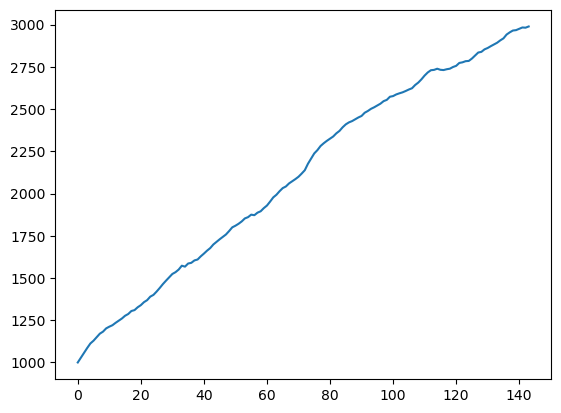

In [14]:
plt.plot(df['Выручка'], label='Выручка')

2. Приводим ряд к стационарному виду

In [18]:
df['Выручка_стац'] = df['Выручка'].diff()
df = df.dropna()
df

,Выручка,Кол-во торговых точек,Инфляция,Выручка_стац
1,1028.891529,1013,1.65,28.891529
2,1058.362078,1037,1.31,29.470549
3,1085.952172,1063,0.69,27.590095
4,1112.591510,1083,0.57,26.639338
5,1129.006608,1107,0.60,16.415098
...,...,...,...,...
139,2967.578088,2818,-0.04,2.337502
140,2975.525361,2820,-0.07,7.947273
141,2983.281426,2830,0.43,7.756064
142,2982.068962,2843,0.71,-1.212463


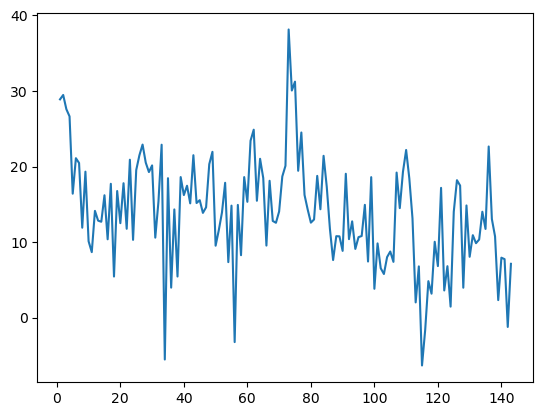

In [20]:
plt.plot(df['Выручка_стац'], label='Выручка стационарный вид')

In [21]:
test = adfuller(df['Выручка_стац'])

print(f'F-stat: {test[0]}')
print(f'p-value: {test[1]}')

F-stat: -4.371156799329208
p-value: 0.0003337335776252847


Заметим, что теперь модель стационарна

3. Построим ACF и PACF ряда, на их основе выдвинем гипотезу о возможной модели

Text(0.5, 1.0, 'График автокорреляции выручки')

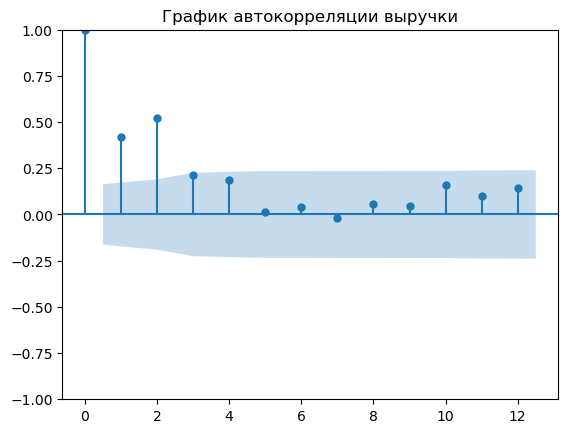

In [23]:
plot_acf(df['Выручка_стац'], lags=12)  
plt.title('График автокорреляции выручки')

Text(0.5, 1.0, 'График частичной автокорреляции выручки')

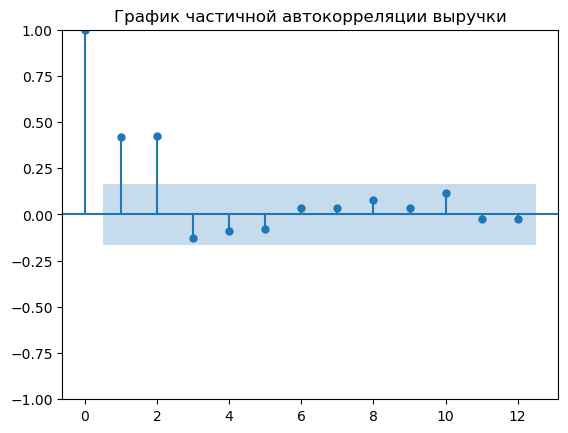

In [24]:
plot_pacf(df['Выручка_стац'], lags=12)  
plt.title('График частичной автокорреляции выручки')

Мне кажется, что это модель ARMA

4. Построить модель.


In [35]:
best_aic = float("inf")
best_order = None

for p in range(4):  # Перебор значений от 0 до 3 для p
    for q in range(4):  # Перебор значений от 0 до 3 для q
        try:
            model = ARIMA(df['Выручка_стац'], order=(p, 0, q))
            results = model.fit()
            aic = results.aic
            if aic < best_aic:
                best_aic = aic
                best_order = (p, 0, q)
        except:
            continue

print(f'Лучшие значения параметров (p, d, q): {best_order} с AIC: {best_aic}')

/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Лучшие значения параметров (p, d, q): (2, 0, 3) с AIC: 915.7887721109716


/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [39]:
best_ARMA_model = sm.tsa.statespace.SARIMAX(
    df['Выручка_стац'], order=(2, 0, 3)
).fit()
print(best_ARMA_model.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  3.22340D+00    |proj g|=  2.21780D-02

At iterate    5    f=  3.22240D+00    |proj g|=  6.43215D-03

At iterate   10    f=  3.22229D+00    |proj g|=  3.68097D-03

At iterate   15    f=  3.21945D+00    |proj g|=  8.97894D-02

At iterate   20    f=  3.19673D+00    |proj g|=  1.60534D-02

At iterate   25    f=  3.19040D+00    |proj g|=  5.15640D-03

At iterate   30    f=  3.18838D+00    |proj g|=  1.16831D-02

At iterate   35    f=  3.18831D+00    |proj g|=  4.71676D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function 

/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
 This problem is unconstrained.


5. Построить схожие модели (например, +-1 лаг в AR/MA части), сравнить модели (критерии AIC, BIC – лучше BIC).


In [40]:
lags_ar = [1, 2, 3]
lags_ma = [1, 2, 3]

best_bic = float('inf')
best_ar_m = None
best_ma_m = None

best_aic = float('inf')
best_ar = None
best_ma = None

# Перебор всех комбинаций лагов для AR и MA частей
for p in lags_ar:
    for q in lags_ma:
        # Строим ARMA модель
        arma_model = ARIMA(df['Выручка_стац'], order=(p, 0, q))
        arma_mfit = arma_model.fit()

        # Строим AR модель
        ar_model = AutoReg(df['Выручка_стац'], lags=p)
        ar_mfit = ar_model.fit()

        # Строим MA модель
        ma_model = ARIMA(df['Выручка_стац'], order=(0, 0, q))
        ma_mfit = ma_model.fit()

        # Вычисляем BIC, AIC для всех моделей
        bic_arma = arma_mfit.bic
        bic_ar = ar_mfit.bic
        bic_ma = ma_mfit.bic

        aic_arma = arma_mfit.aic
        aic_ar = ar_mfit.aic
        aic_ma = ma_mfit.aic

        # Сравниваем суммарное BIC и AIC для AR, MA и ARMA моделей
        if bic_arma + bic_ar + bic_ma < best_bic:
            best_bic = bic_arma + bic_ar + bic_ma
            best_ar_m = ar_mfit
            best_ma_m = ma_mfit
            best_arma_m = arma_mfit

        if aic_arma + aic_ar + aic_ma < best_aic:
            best_aic = aic_arma + aic_ar + aic_ma
            best_ar = ar_mfit
            best_ma = ma_mfit
            best_arma = arma_mfit

# Выводим лучшие модели и их BIC значения
print('Лучшая AR модель (BIC):')
print(best_ar_m.summary())
print('\nЛучшая MA модель (BIC):')
print(best_ma_m.summary())
print('\nЛучшая ARMA модель (BIC):')
print(best_arma_m.summary())
print(f'Лучшая AR модель по показателю BIC: {best_ar_m.bic}')
print(f'Лучшая MA модель по показателю BIC: {best_ma_m.bic}')
print(f'Лучшая ARMA модель по показателю BIC: {best_arma_m.bic}')

# Выводим лучшие модели и их AIC значения
print('Лучшая AR модель (AIC):')
print(best_ar.summary())
print('\nЛучшая MA модель (AIC):')
print(best_ma.summary())
print('\nЛучшая ARMA модель (AIC):')
print(best_arma.summary())
print(f'Лучшая AR модель по показателю AIC: {best_ar.aic}')
print(f'Лучшая MA модель по показателю AIC: {best_ma.aic}')
print(f'Лучшая ARMA модель по показателю AIC: {best_arma.aic}')

/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Лучшая AR модель (BIC):
                            AutoReg Model Results                             
Dep. Variable:           Выручка_стац   No. Observations:                  143
Model:                     AutoReg(2)   Log Likelihood                -446.114
Method:               Conditional MLE   S.D. of innovations              5.726
Date:                Fri, 03 Nov 2023   AIC                            900.228
Time:                        18:51:46   BIC                            912.023
Sample:                             2   HQIC                           905.021
                                  143                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               4.3874      1.218      3.603      0.000       2.001       6.774
Выручка_стац.L1     0.2091      0.074      2.816      0.005       0.064       0.355
Выручка_

/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided 

Таким образом, можно сделать вывод, что моя модель это MA

Теперь проверим на стационарность инфляцию и количество торговых точек

In [42]:
test = adfuller(df['Кол-во торговых точек'])

print(f'F-stat: {test[0]}')
print(f'p-value: {test[1]}')

F-stat: -1.8402304581917721
p-value: 0.360679109655775


In [43]:
test = adfuller(df['Инфляция'])

print(f'F-stat: {test[0]}')
print(f'p-value: {test[1]}')

F-stat: -2.33015388503229
p-value: 0.16242706144673041


Заметим, что сезонность в обоих случаях нестационарна. 

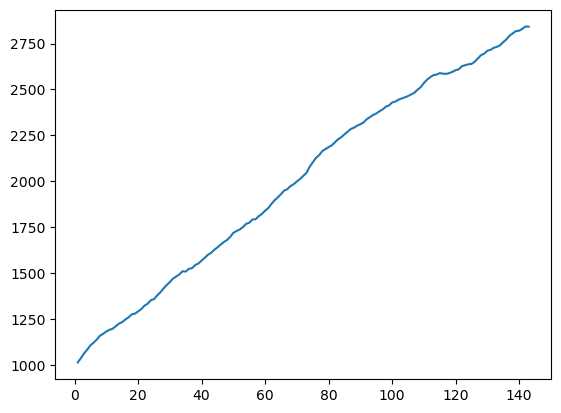

In [44]:
plt.plot(df['Кол-во торговых точек'], label='Кол-во торговых точек')

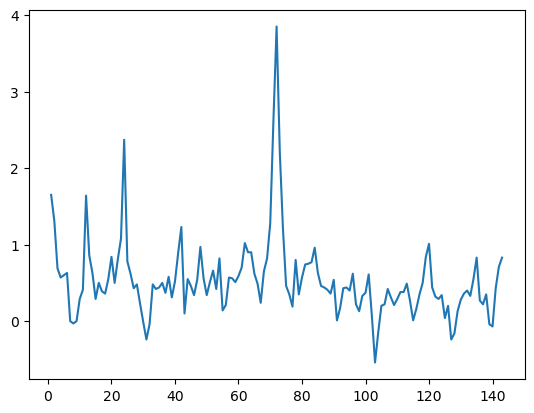

In [45]:
plt.plot(df['Инфляция'], label='Инфляция')

Приведем к стационарному виду

In [46]:
df['Кол-во торговых точек_стац'] = df['Кол-во торговых точек'].diff()
df = df.dropna()
df

/tmp/ipykernel_72531/769214544.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Кол-во торговых точек_стац'] = df['Кол-во торговых точек'].diff()


,Выручка,Кол-во торговых точек,Инфляция,Выручка_стац,Кол-во торговых точек_стац
2,1058.362078,1037,1.31,29.470549,24.0
3,1085.952172,1063,0.69,27.590095,26.0
4,1112.591510,1083,0.57,26.639338,20.0
5,1129.006608,1107,0.60,16.415098,24.0
6,1150.116039,1121,0.63,21.109431,14.0
...,...,...,...,...,...
139,2967.578088,2818,-0.04,2.337502,12.0
140,2975.525361,2820,-0.07,7.947273,2.0
141,2983.281426,2830,0.43,7.756064,10.0
142,2982.068962,2843,0.71,-1.212463,13.0


In [47]:
df['Инфляция_стац'] = df['Инфляция'].diff()
df = df.dropna()
df

/tmp/ipykernel_72531/3033596647.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Инфляция_стац'] = df['Инфляция'].diff()


,Выручка,Кол-во торговых точек,Инфляция,Выручка_стац,Кол-во торговых точек_стац,Инфляция_стац
3,1085.952172,1063,0.69,27.590095,26.0,-0.62
4,1112.591510,1083,0.57,26.639338,20.0,-0.12
5,1129.006608,1107,0.60,16.415098,24.0,0.03
6,1150.116039,1121,0.63,21.109431,14.0,0.03
7,1170.588332,1138,0.00,20.472293,17.0,-0.63
...,...,...,...,...,...,...
139,2967.578088,2818,-0.04,2.337502,12.0,-0.39
140,2975.525361,2820,-0.07,7.947273,2.0,-0.03
141,2983.281426,2830,0.43,7.756064,10.0,0.50
142,2982.068962,2843,0.71,-1.212463,13.0,0.28


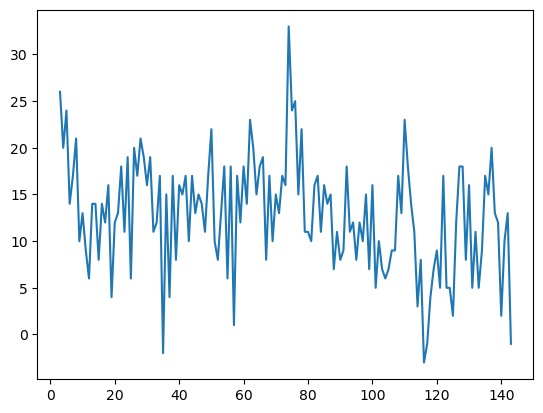

In [48]:
plt.plot(df['Кол-во торговых точек_стац'], label='Кол-во торговых точек_стац')

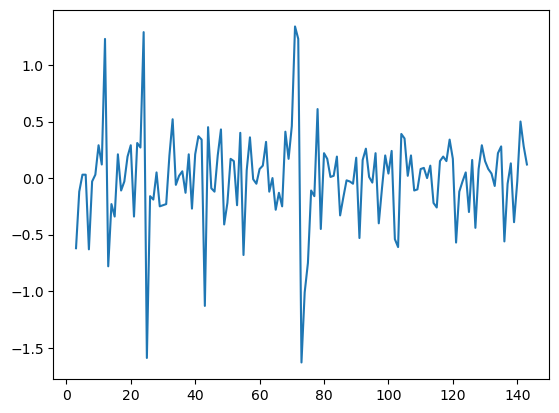

In [49]:
plt.plot(df['Инфляция_стац'], label='Инфляция_стац')

Построим VAR с лагом 1

In [50]:
df2 = df[['Инфляция_стац', 'Кол-во торговых точек_стац', 'Выручка_стац']]

In [57]:
model1 = VAR(df2)
result1 = model1.fit(1)
result1.summary()

/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 03, Nov, 2023
Time:                     19:13:15
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    3.44491
Nobs:                     140.000    HQIC:                   3.29524
Log likelihood:          -807.448    FPE:                    24.3570
AIC:                      3.19277    Det(Omega_mle):         22.3831
--------------------------------------------------------------------
Results for equation Инфляция_стац
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 0.224415         0.096459            2.327           0.020
L1.Инфляция_стац                     -0.065554         0.086136           -0.761     

In [58]:
model2 = VAR(df2)
result2 = model1.fit(2)
result2.summary()

/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 03, Nov, 2023
Time:                     19:13:18
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    3.64709
Nobs:                     139.000    HQIC:                   3.38391
Log likelihood:          -793.358    FPE:                    24.6310
AIC:                      3.20375    Det(Omega_mle):         21.2554
--------------------------------------------------------------------
Results for equation Инфляция_стац
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 0.185103         0.109126            1.696           0.090
L1.Инфляция_стац                     -0.067800         0.086427           -0.784     

In [59]:
model3 = VAR(df2)
result3 = model1.fit(3)
result3.summary()

/Users/karina/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 03, Nov, 2023
Time:                     19:13:20
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                    3.80385
Nobs:                     138.000    HQIC:                   3.42609
Log likelihood:          -775.998    FPE:                    23.7660
AIC:                      3.16749    Det(Omega_mle):         19.2668
--------------------------------------------------------------------
Results for equation Инфляция_стац
                                   coefficient       std. error           t-stat            prob
------------------------------------------------------------------------------------------------
const                                 0.228842         0.120637            1.897           0.058
L1.Инфляция_стац                     -0.093782         0.088859           -1.055     

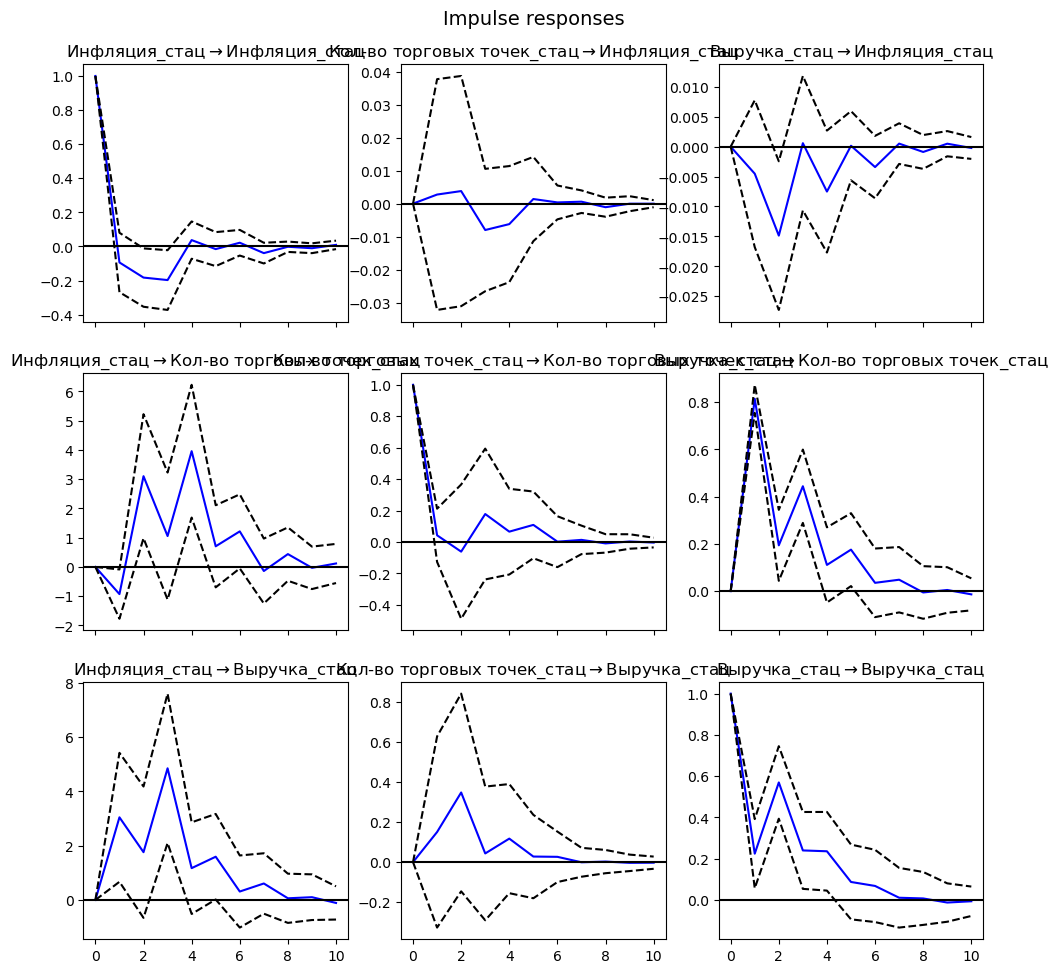

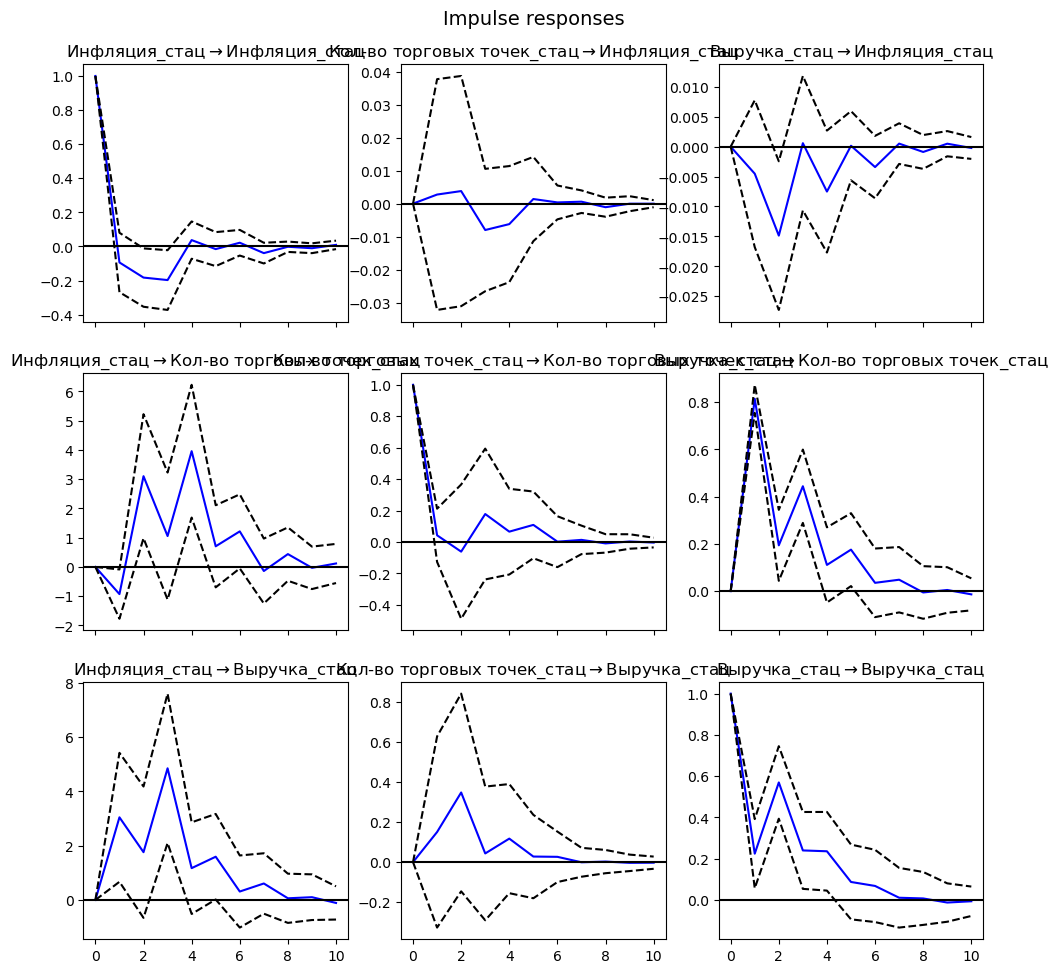

In [60]:
result3.irf().plot()